In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

In [2]:
plt.style.use("~/nice.mplstyle")

In [3]:
data_dir = "/pscratch/sd/t/timothys/nested-eagle/1.00deg-15km"
kw = {"decode_timedelta": True}

In [4]:
nice_names = {
    "sp": "Surface Pressure",
    "u10": "10m Zonal Wind",
    "v10": "10m Meridional Wind",
    "t2m": "2m Temperature",
    "sh2": "2m Specific Humidity",
    "gh": "Geopotential Height",
    "u": "Zonal Wind",
    "v": "Meridional Wind",
    "w": "Vertical Velocity",
    "t": "Temperature",
    "q": "Specific Humidity",
}

In [5]:
def plot_spectra(fhr, dsdict, show_error=False):

    try:
        outer = list(dsdict.values())[0]
        xds = list(outer.values())[0]
        ncols = len(xds.data_vars)
    except:
        xds = list(dsdict.values())[0]
        ncols = len(xds.data_vars)
        
    fig, axs = plt.subplots(1, ncols, figsize=(5*ncols, 4.5), constrained_layout=True, sharey=True)

    for label, xds in dsdict.items():
        for varname, ax in zip(xds.data_vars, axs):
            plotme = xds[varname].sel(fhr=fhr)
            if show_error:
                plotme = plotme - xds[varname].sel(fhr=0)
                plotme = plotme / np.abs(xds[varname].sel(fhr=0))
            plotme.plot(ax=ax, label=label)

    for varname, ax in zip(xds.data_vars, axs):
        # Now use the last dataset to get fhr0 as a "truth" comparison
        if not show_error:
            xds[varname].sel(fhr=0).plot(ax=ax, label="Analysis", color="gray")
        else:
            ax.axhline(y=0, color="gray")
            

    for varname, ax in zip(xds.data_vars, axs):
        ylabel = "$P(k)$" if not show_error else "Power Relative Error"
        ax.set(
            yscale="log" if not show_error else "linear",
            xscale="log",
            title=f"{nice_names[varname]}\nLead Time = {fhr}h",
            xlabel="$k$",
            ylabel=ylabel if ax.get_subplotspec().is_first_col() else "",
        )
        ax.legend()
        if show_error:
            ax.grid()
    return fig, axs
    #fig.savefig(f"figures/channels_spectra_{fhr:03d}h.jpeg", bbox_inches="tight", dpi=300)

## CRPS

In [7]:
loss = {
    domain: {
        "mse06h": xr.open_dataset(f"/pscratch/sd/t/timothys/nested-eagle/1.00deg-15km/mse06h/experiments/regularization/wp01/inference-validation/spectra.nested-{domain.lower()}.nc", **kw),
        "crps06h - gridx4": xr.open_dataset(f"/pscratch/sd/t/timothys/nested-eagle/1.00deg-15km/crps06h/experiments/base/no-truncation/inference-validation/spectra.nested-{domain.lower()}.nc", **kw),
        #"crps06h - 32": xr.open_dataset(f"/pscratch/sd/t/timothys/nested-eagle/1.00deg-15km/crps06h/experiments/base/noise32/inference-validation/spectra.nested-{domain.lower()}.nc", **kw),
        #"crps06h - 128": xr.open_dataset(f"/pscratch/sd/t/timothys/nested-eagle/1.00deg-15km/crps06h/experiments/base/noise128/inference-validation/spectra.nested-{domain.lower()}.nc", **kw),
        #"crps06h - shared 32": xr.open_dataset(f"/pscratch/sd/t/timothys/nested-eagle/1.00deg-15km/crps06h/experiments/base/sharednoise32/inference-validation/spectra.nested-{domain.lower()}.nc", **kw),
        "crps06h - shared mlp 32": xr.open_dataset(f"/pscratch/sd/t/timothys/nested-eagle/1.00deg-15km/crps06h/experiments/base/mlpnoise32/inference-validation/spectra.nested-{domain.lower()}.nc", **kw),
    }
    for domain in ["LAM", "Global"]
}

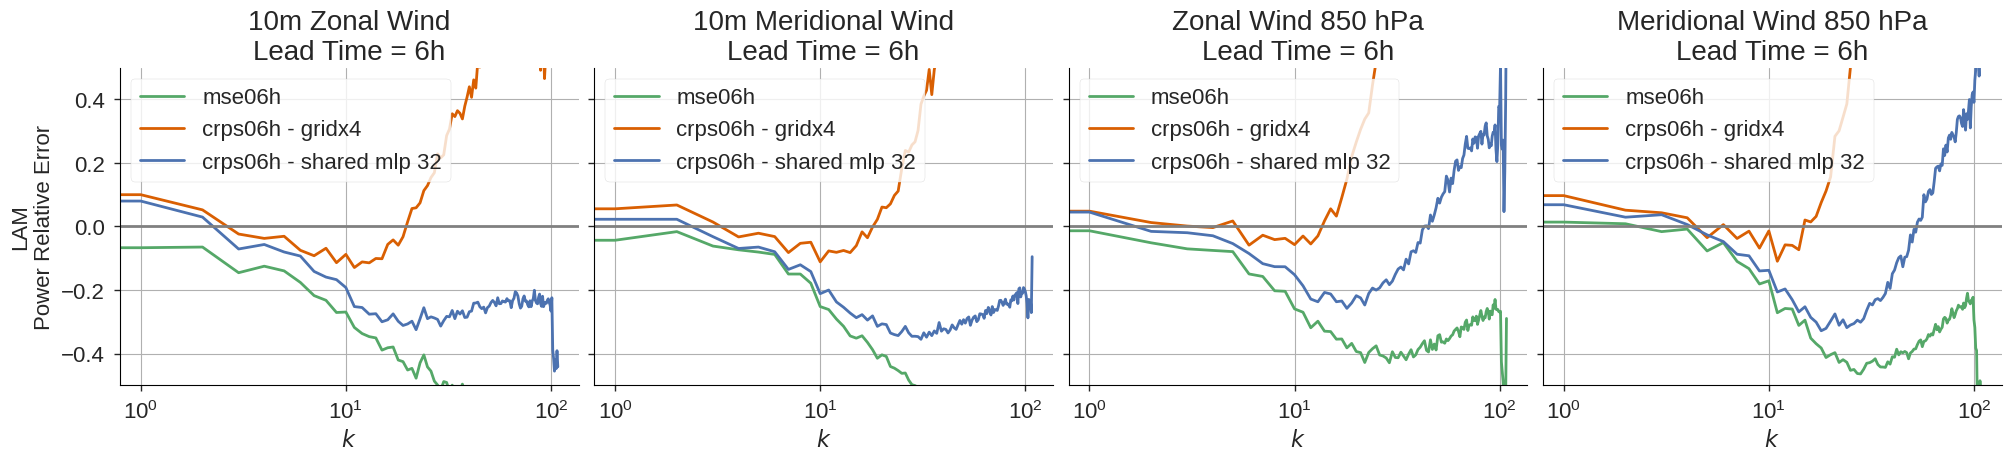

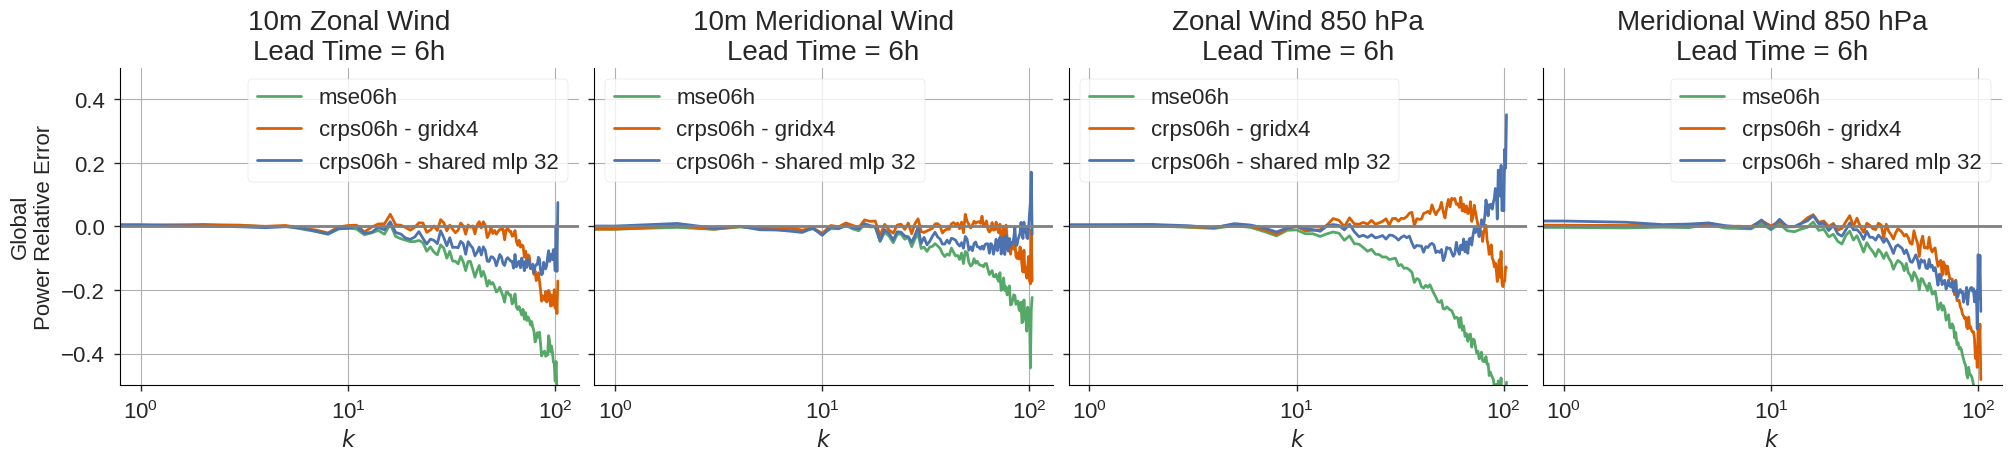

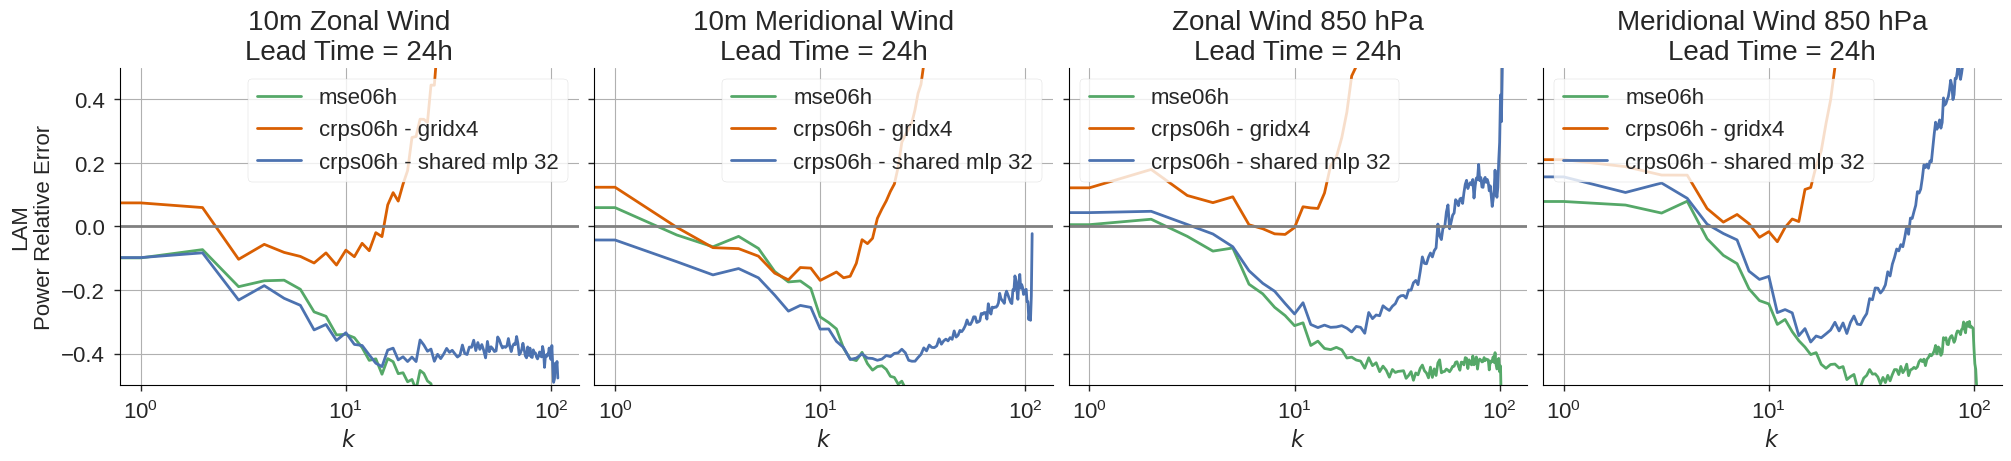

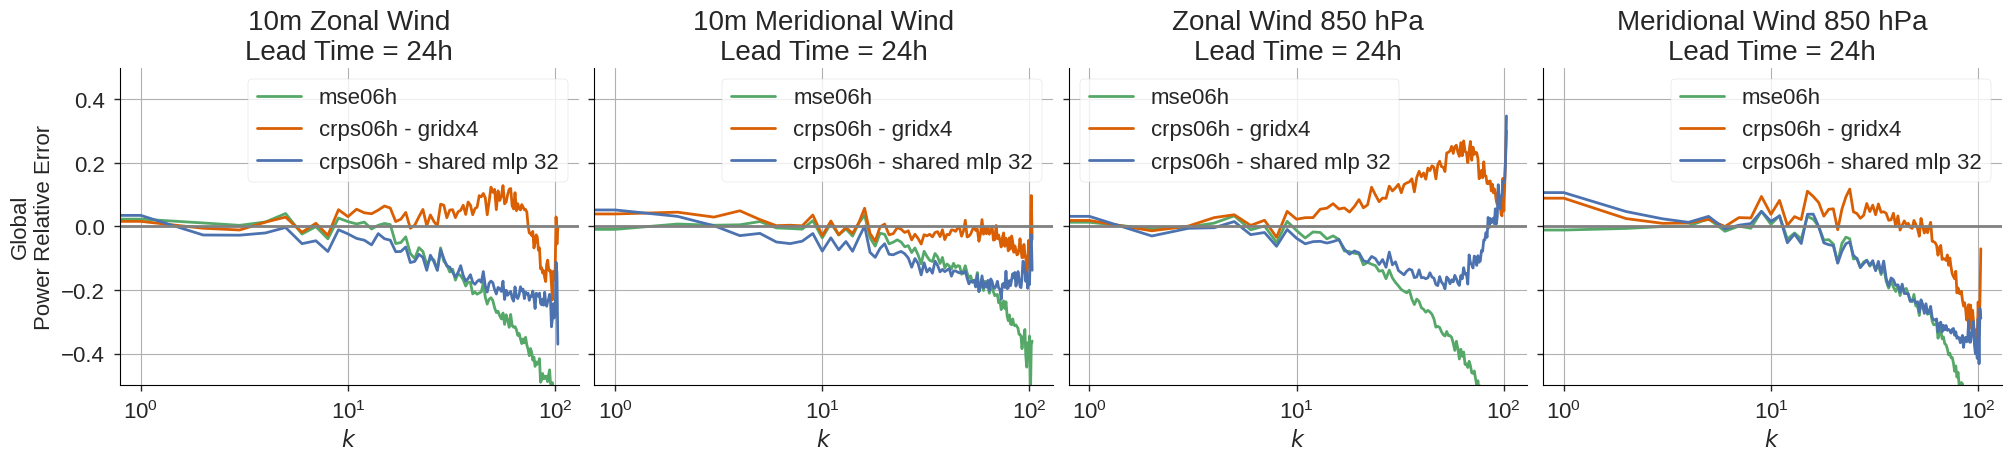

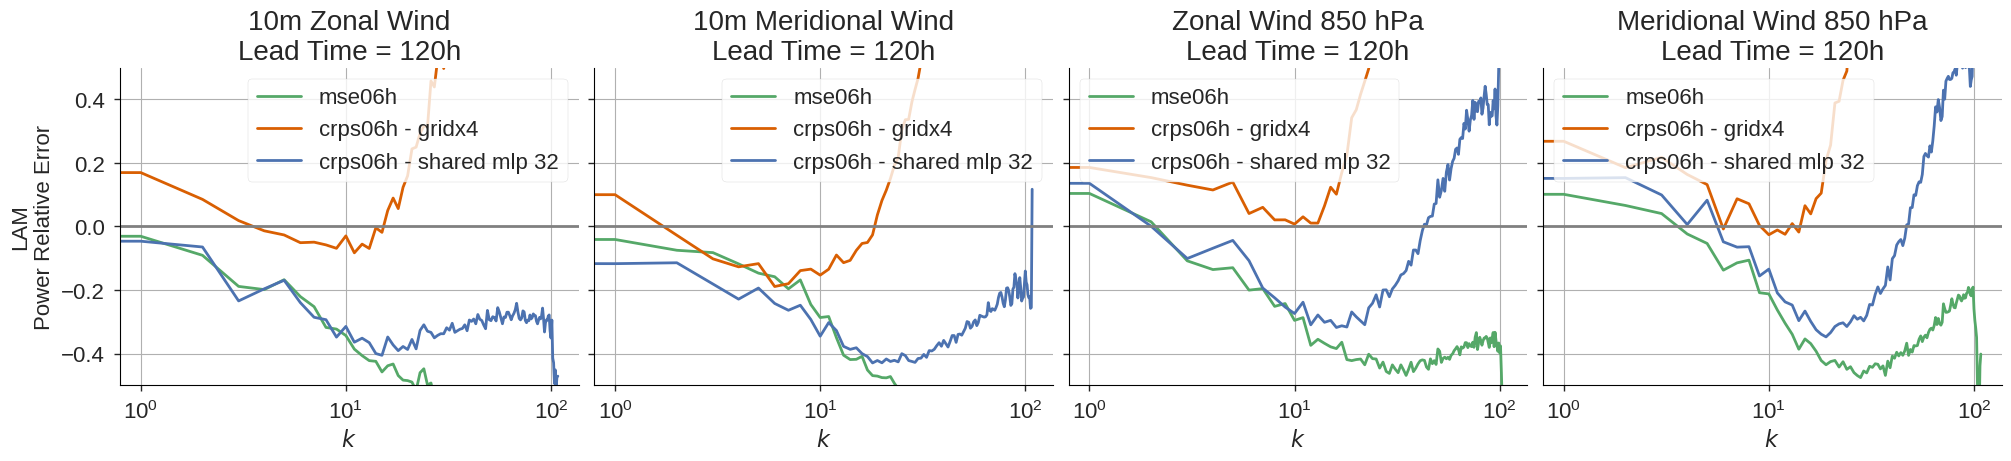

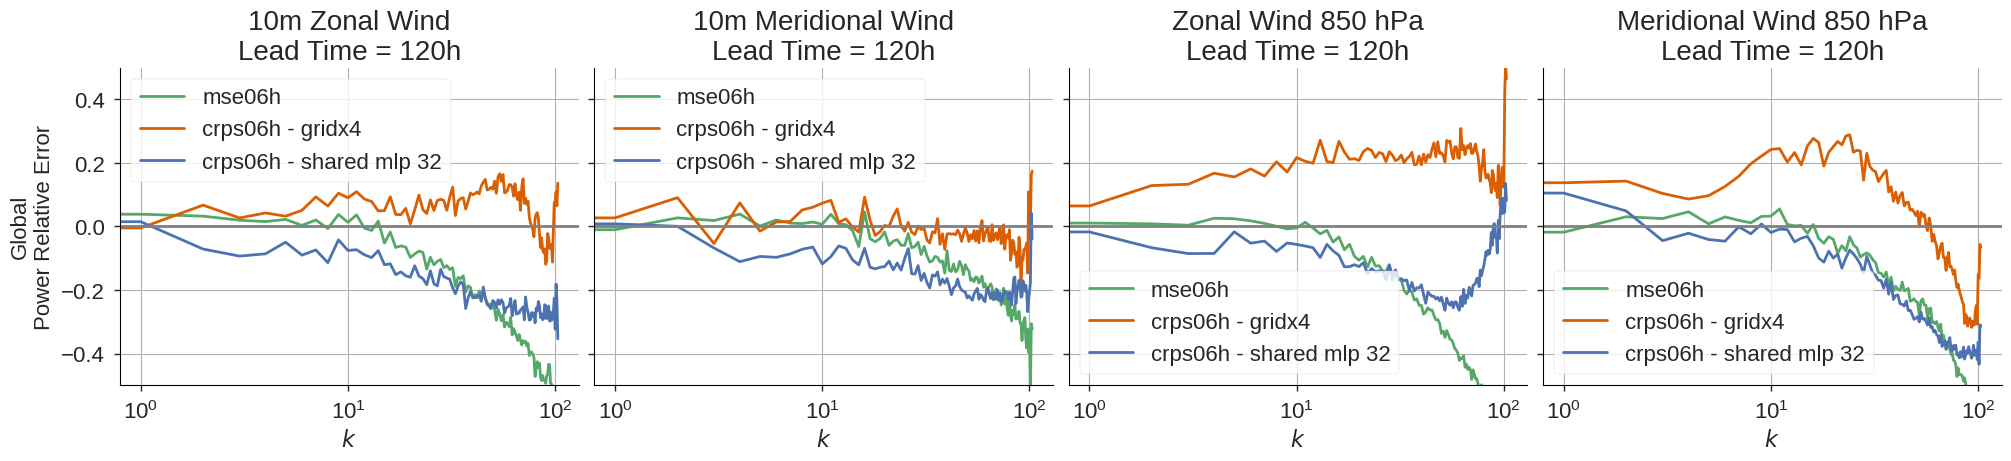

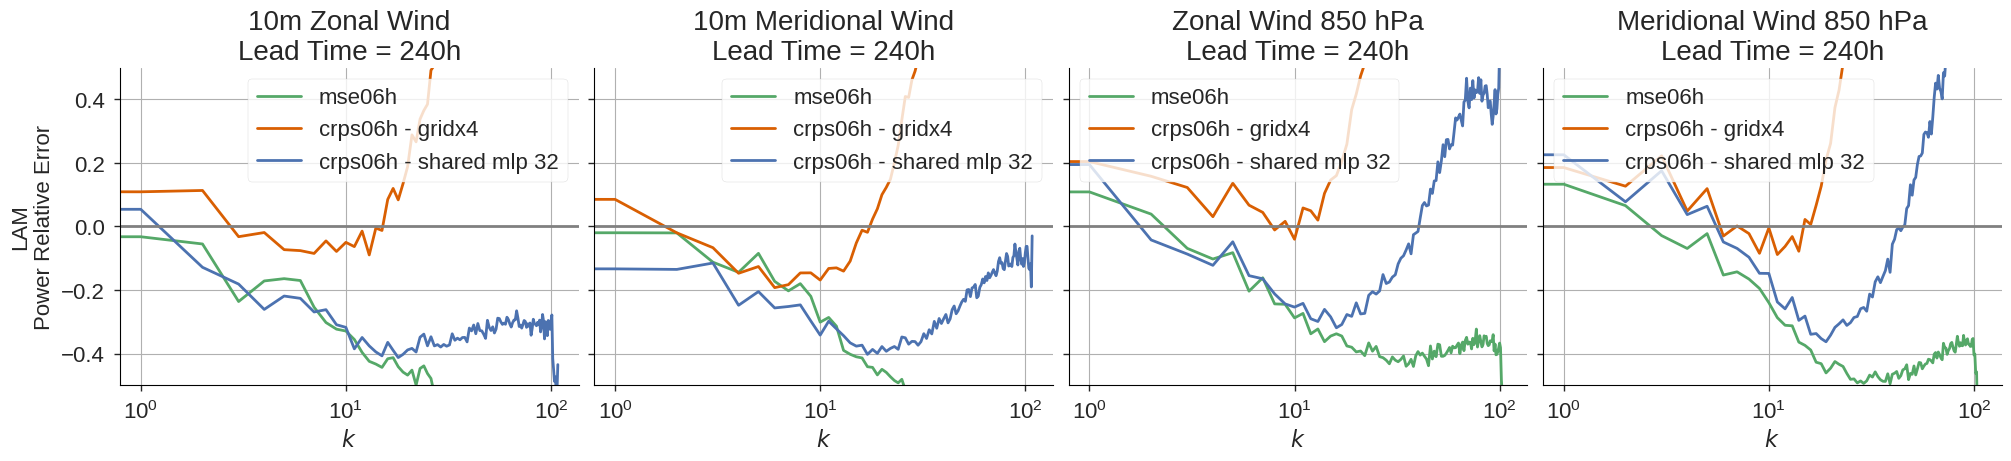

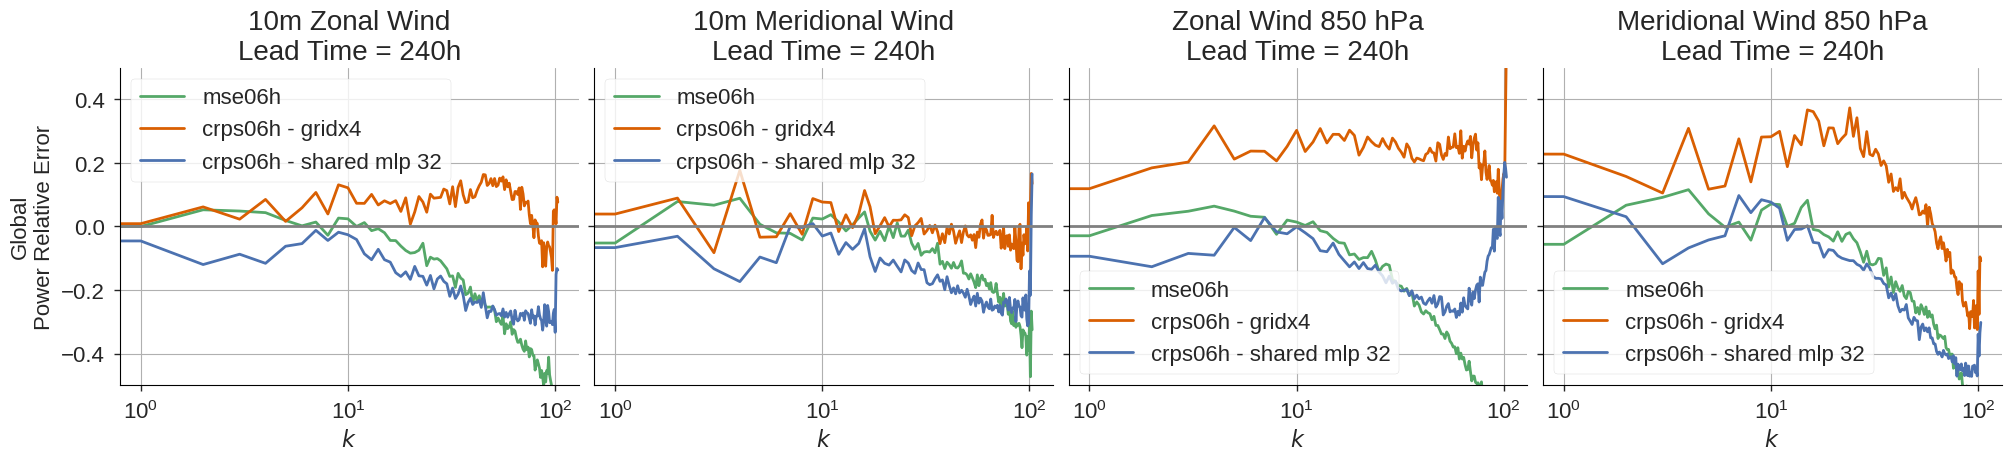

In [12]:
show_error=True
for fhr in [6, 24, 120, 240]:
    for name, dsdict in loss.items():
        fig, axs = plot_spectra(fhr=fhr, dsdict=dsdict, show_error=show_error)
        for idx in [2, 3]:
            axs[idx].set_title(axs[idx].get_title().replace("Wind", "Wind 850 hPa"))
        axs[0].set_ylabel(f"{name}\n" + axs[0].get_ylabel())
        for ax in axs:
            ax.set(ylim=[-.5,.5])

        suffix = f"{name.lower()}_{fhr:03d}h"
        fname = f"figures/spectra_error_{suffix}" if show_error else f"figures/spectra_{suffix}"
        fig.savefig(fname, bbox_inches="tight", dpi=300)

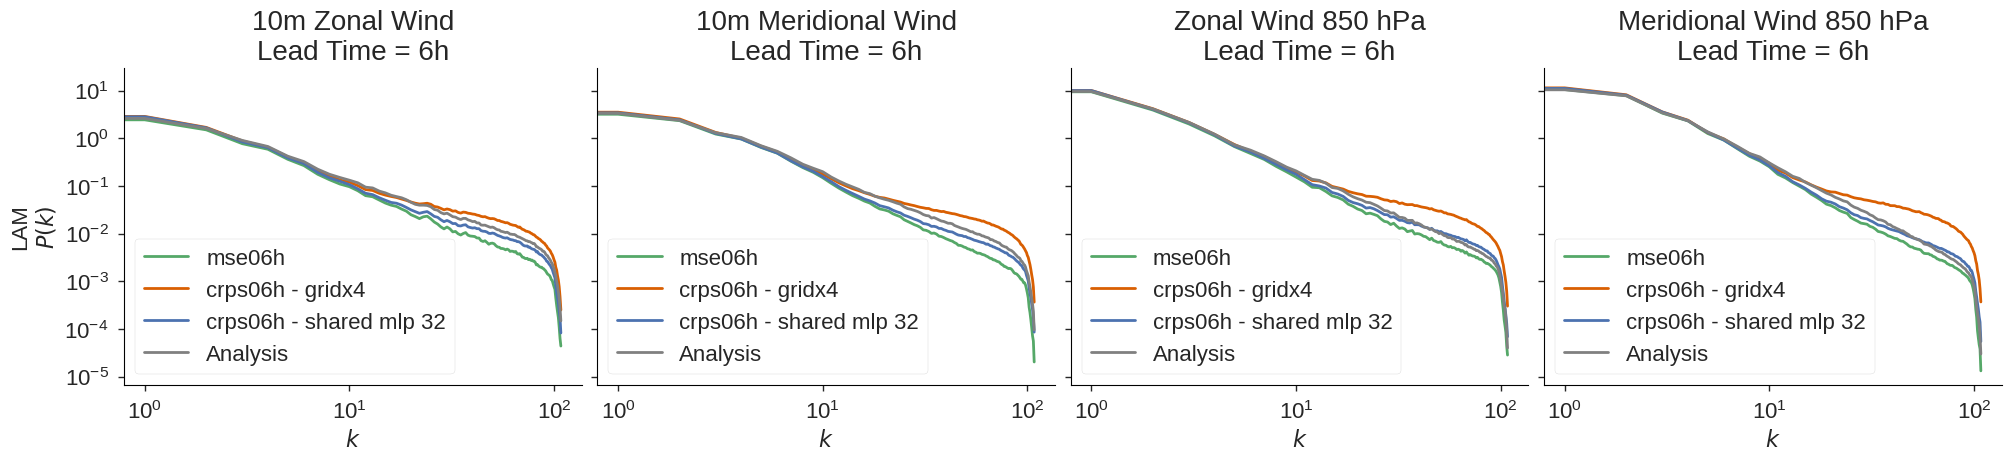

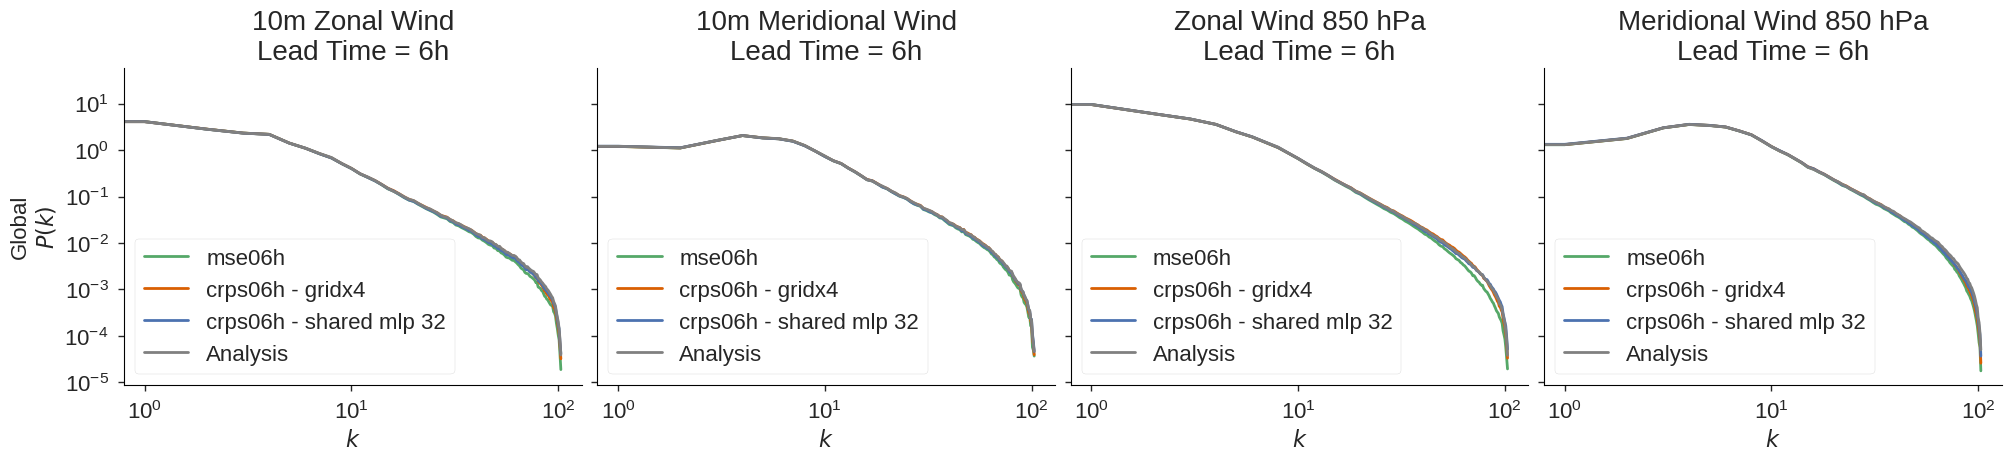

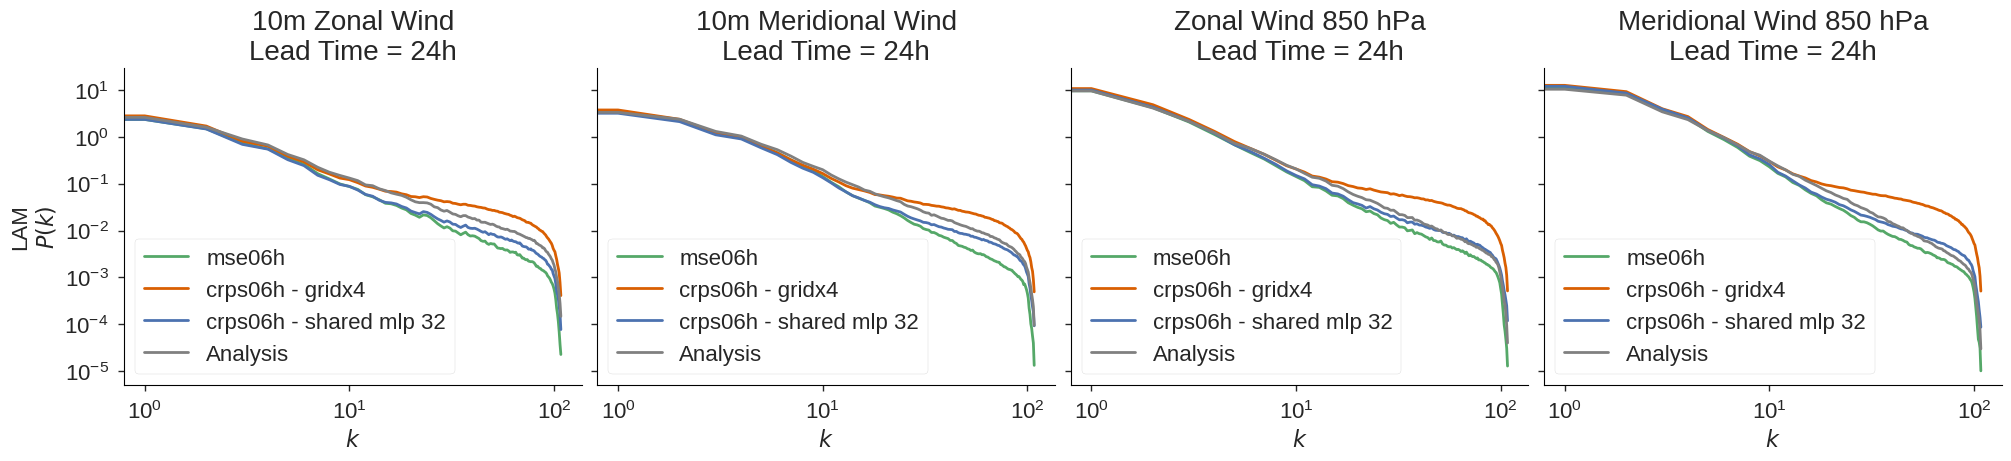

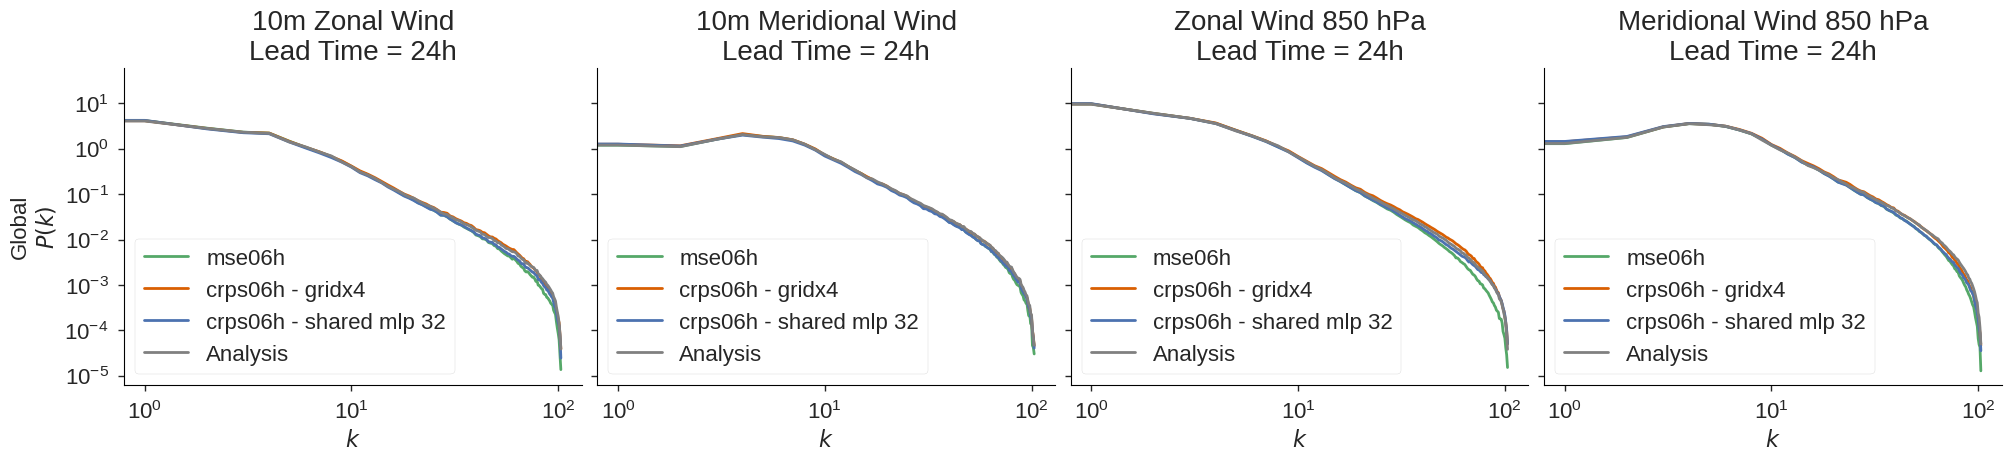

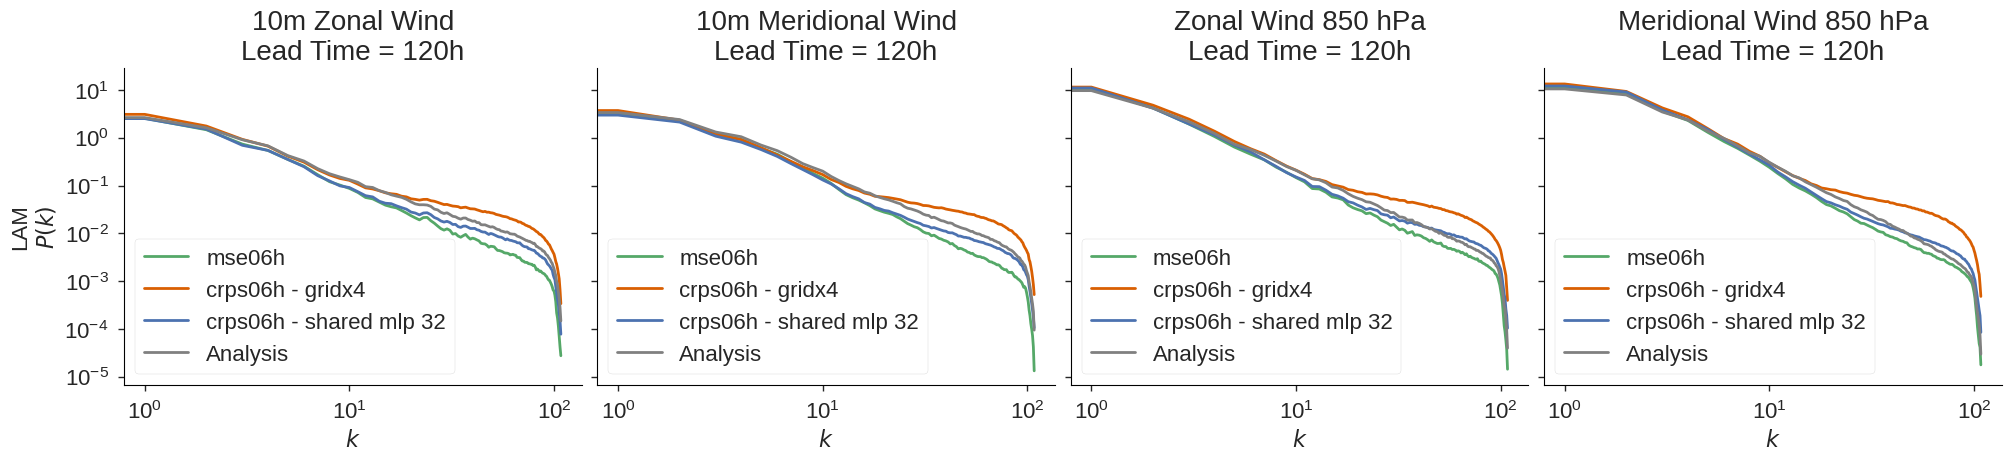

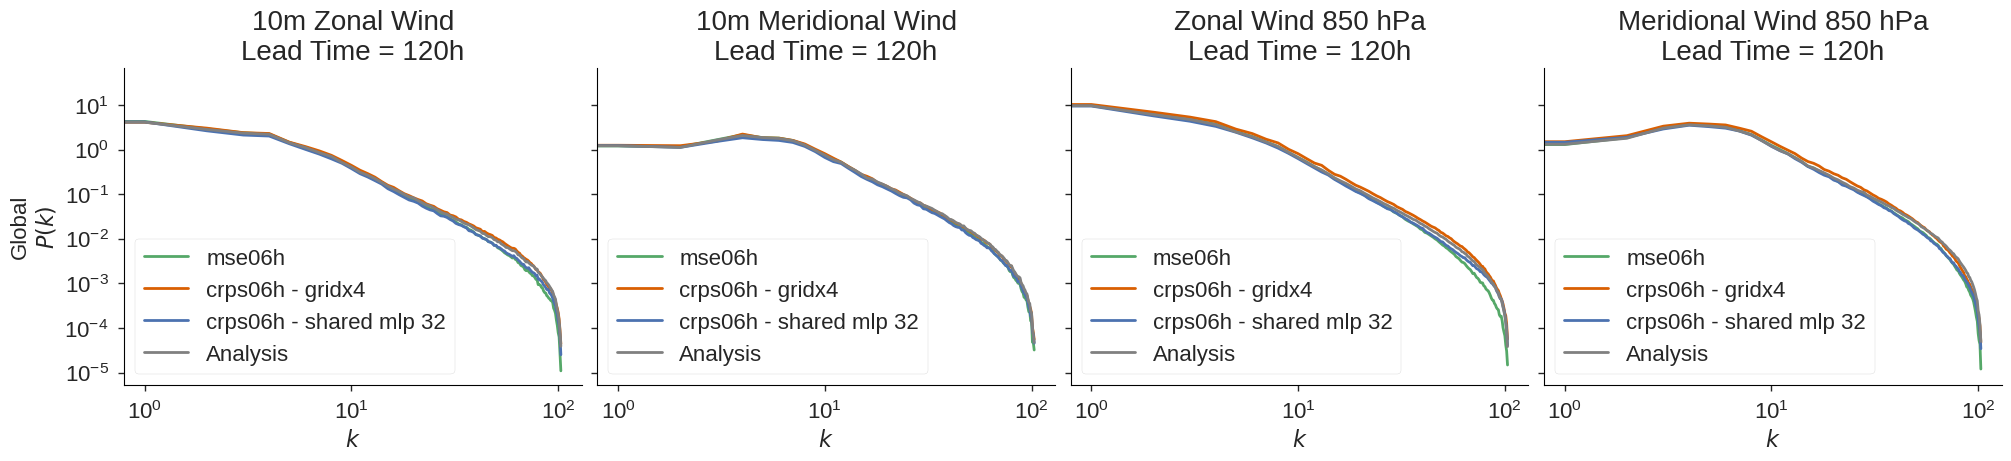

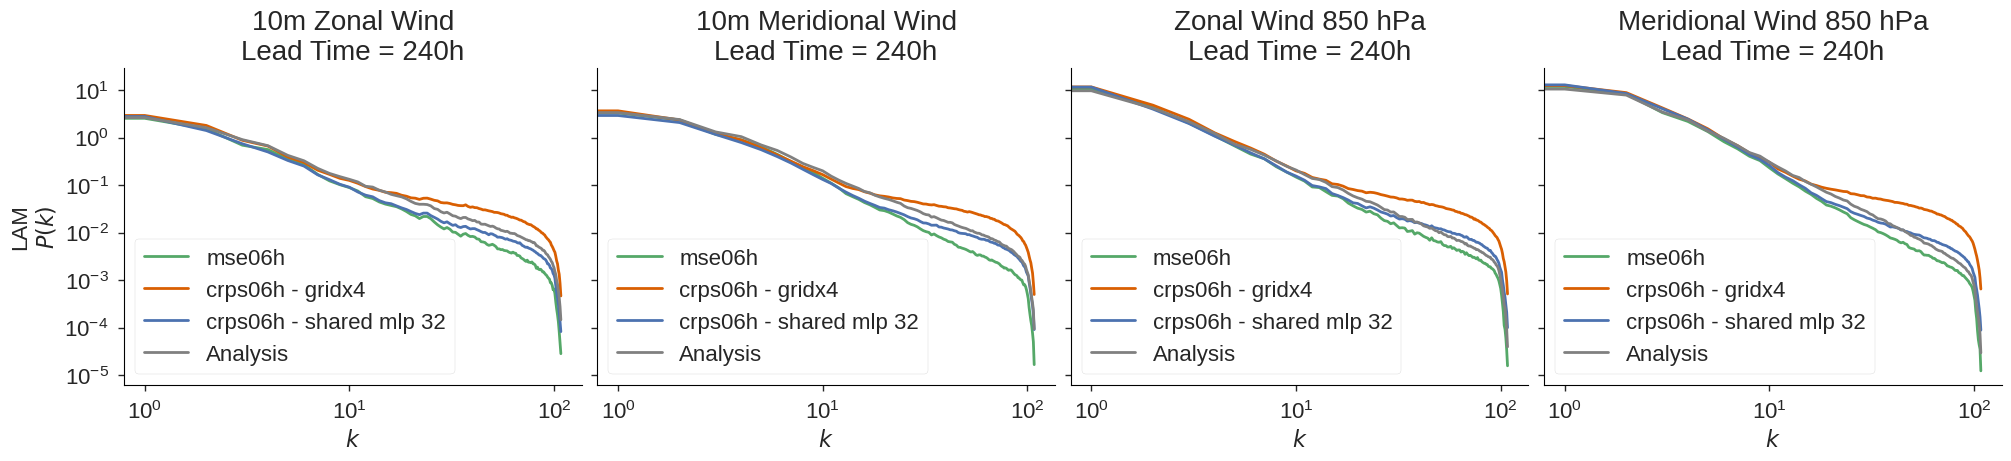

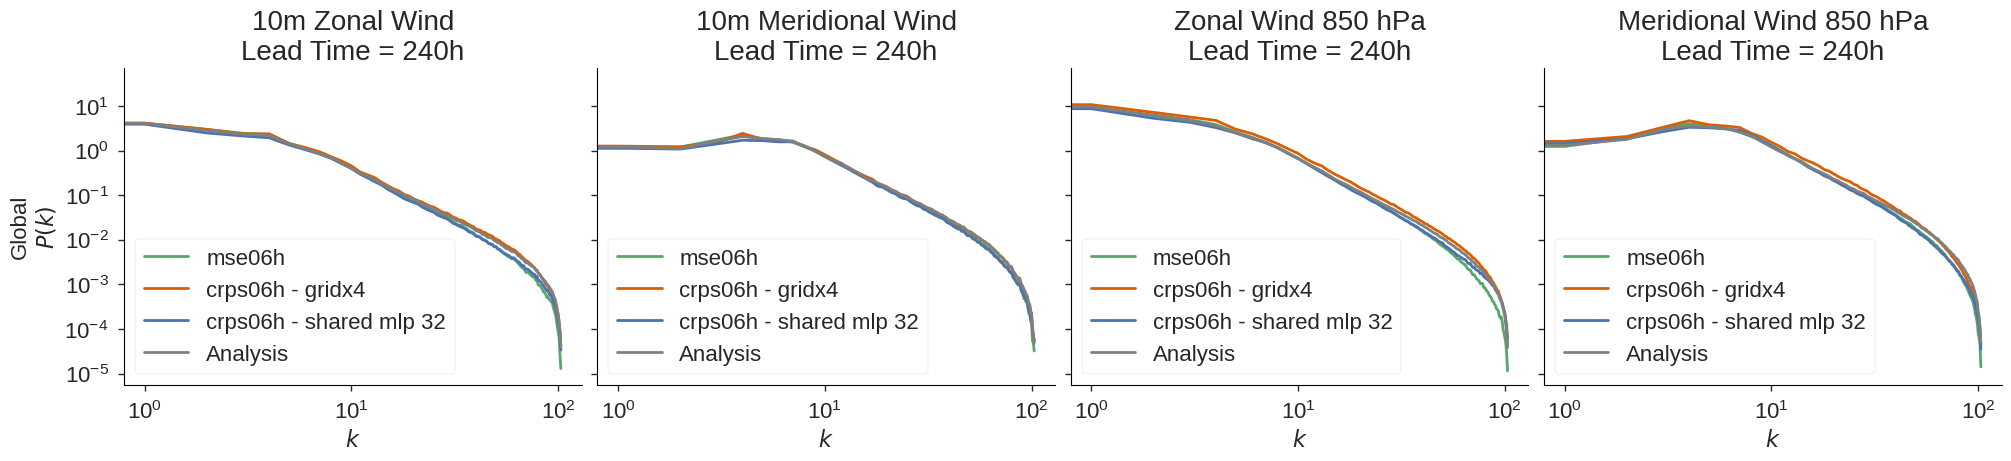

In [11]:
show_error=False
for fhr in [6, 24, 120, 240]:
    for name, dsdict in loss.items():
        fig, axs = plot_spectra(fhr=fhr, dsdict=dsdict, show_error=show_error)
        for idx in [2, 3]:
            axs[idx].set_title(axs[idx].get_title().replace("Wind", "Wind 850 hPa"))
        axs[0].set_ylabel(f"{name}\n" + axs[0].get_ylabel())
        suffix = f"{name.lower()}_{fhr:03d}h"
        fname = f"figures/spectra_error_{suffix}" if show_error else f"figures/spectra_{suffix}"
        fig.savefig(fname, bbox_inches="tight", dpi=300)